<a href="https://colab.research.google.com/github/BiancaMMoreno/Artgan-Implementation/blob/master/INF554_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import and save into google drive
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/INF554/project'
%ls

Mounted at /content/drive
/content/drive/My Drive/INF554/project
baseline.py               mean_predictions.txt
constant_predictions.txt  prediction_decisiontreesimple.txt
data/                     prediction_decisiontree.txt
dummy_baseline.py         twitter
hist_age.png              twitter.pdf
Log_ROC.png


## Import libraries


In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import *
from collections import Counter
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

## Open dataset

In [ ]:
data_path = "data" # main path to our dataset
train_path = os.path.join(data_path, 'train.csv')
eval_path = os.path.join(data_path, 'evaluation.csv')

In [ ]:
train_df = pd.read_csv(train_path, index_col='id')
eval_df = pd.read_csv(eval_path, index_col='id')

In [ ]:
train_df.head()

Data visualization

## Data transformation

In [ ]:

def numerical_to_categorical(df, column, cat=None, dummies=False):
  if column not in df:
    raise Exception("'{}' column not found in the dataframe".format(column))
  if cat is None:
    out, cat = pd.cut(df[column], bins=50, retbins=True)
  else:
    out = pd.cut(df[column], bins=cat)
  if dummies:
    out = out.to_frame('values')
    dummies = pd.get_dummies(out['values'])
    df = df.drop([column], axis=1)
    return pd.concat([df, dummies], axis=1, join='inner'), cat
  else:
    cat = np.array([0, 1, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, np.inf])
    df[column+"_interval"] = pd.cut(df[column], bins=cat, right=False)
    ord_enc = OrdinalEncoder()
    df[column+"_interval"] = ord_enc.fit_transform(df[[column+"_interval"]]).astype(int)
    return df



### timestamp

For this column, we split into 24 columns based on intervals of one hour per day equivalent to the time of tweets. These columns will have boolean values (0 or 1), being 1 if the tweet was posted in that interval, 0 if not.

In [ ]:
def transform_timestamp(df):
  if 'timestamp' not in df:
    raise Exception("'timestamp' column not found in the dataframe")
  # we must divide by 1000 to transform into ms
  df['time'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp']/ 1000).hour, axis=1)
  new_c = {i: '{} - {}'.format(i, i + 1) for i in range(24)}
  dummies = pd.get_dummies(df['time'])
  dummies = dummies.rename(columns=new_c)
  df = df.drop(['timestamp', 'time'], axis=1)
  return pd.concat([df, dummies], axis=1, join='inner')
train_df = transform_timestamp(train_df)
eval_df = transform_timestamp(eval_df)

In [ ]:
# hour
"""
def transform_timestamp(df):
  if 'timestamp' not in df:
    raise Exception("'timestamp' column not found in the dataframe")
  # we must divide by 1000 to transform into ms
  df['time'] = df.apply(lambda x: (datetime.fromtimestamp(x['timestamp']/ 1000).hour) / 24, axis=1)
  df = df.drop(['timestamp'], axis=1)
  return df
train_df = transform_timestamp(train_df)
eval_df = transform_timestamp(eval_df)
"""

'\ndef transform_timestamp(df):\n  if \'timestamp\' not in df:\n    raise Exception("\'timestamp\' column not found in the dataframe")\n  # we must divide by 1000 to transform into ms\n  df[\'time\'] = df.apply(lambda x: (datetime.fromtimestamp(x[\'timestamp\']/ 1000).hour) / 24, axis=1)\n  df = df.drop([\'timestamp\'], axis=1)\n  return df\ntrain_df = transform_timestamp(train_df)\neval_df = transform_timestamp(eval_df)\n'

### urls

Transform into a boolean value (0 if there isn't a url, 1 if there is)

In [ ]:
def transform_urls(df):
  if 'urls' not in df:
    raise Exception("'{}' column not found in the dataframe".format('urls'))
  df["urls"] = df.apply(lambda x: 0 if x["urls"] != x["urls"] else 1, axis=1)
  return df 
train_df = transform_urls(train_df)
eval_df = transform_urls(eval_df)

### text

Drop this column for now

In [ ]:
train_df = train_df.drop(['text'], axis=1)
eval_df = eval_df.drop(['text'], axis=1)

### user_mentions

Count the number of mentions and normalize our values

In [ ]:
def count_and_normalize(df, column, mean=None, std=None):
  if column not in df:
    raise Exception("'{}' column not found in the dataframe".format(column))
  df = df.copy()
  df[column].fillna("", inplace=True)
  df[column] = df.apply(lambda x: 0 if x[column] == "" else len(x[column].split(",")), axis=1)
  return df, mean, std
  # return normalize(df, column, mean=mean, std=std)
train_df, mean, std = count_and_normalize(train_df, 'user_mentions')
eval_df, _, _ = count_and_normalize(eval_df, 'user_mentions', mean, std)

### user_verified

Transform into 0 and 1 values

In [ ]:
train_df, mean, std = count_and_normalize(train_df, 'hashtags')
eval_df, _, _ = count_and_normalize(eval_df, 'hashtags', mean, std)

### hashtags

Count the number of hashtags

In [ ]:
def transform_user_verified(df):
  if 'user_verified' not in df:
    raise Exception("'user_verified' column not found in the dataframe")
  df['user_verified'] *= 1
  return df
train_df = transform_user_verified(train_df)
eval_df = transform_user_verified(eval_df)

### retweet_count
 
 Make a new categorical column with the retweet intervals

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

cat = np.array([0, 1, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, np.inf])
mean = [0, 5, 55, 300, 750, 2500, 7500, 25000, 75000, 100000]
train_df = numerical_to_categorical(train_df, "retweet_count", cat=cat, dummies=False)

Let's visualize the histogram of the distribution of tweets on the intervals

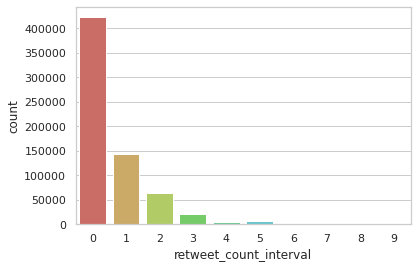

In [ ]:
from sklearn import preprocessing
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='retweet_count_interval',data=train_df,palette='hls')
plt.show()


We see that they are really unbalanced. Probably this means the decision tree algo will work better if we assign some kind of weight distribution to the categories.

In [ ]:
train_dt = train_df.drop(['retweet_count'], axis=1)
train_dt.head()

,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,0 - 1,1 - 2,2 - 3,3 - 4,4 - 5,5 - 6,6 - 7,7 - 8,8 - 9,9 - 10,10 - 11,11 - 12,12 - 13,13 - 14,14 - 15,15 - 16,16 - 17,17 - 18,18 - 19,19 - 20,20 - 21,21 - 22,22 - 23,23 - 24,retweet_count_interval
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,68460,1101,1226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,309,51,202,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,3241,1675,2325,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,32327,667,304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,581,42,127,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Decision Tree

We first try a version of decision tree with the rough dataset.

In [ ]:
X = train_dt.loc[:, train_dt.columns != 'retweet_count_interval']
y = train_dt.loc[:, train_dt.columns == 'retweet_count_interval']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

In [ ]:
#print(clf.score(X_test, y_test))
y_pred = clf.predict(eval_df)

In [ ]:
def calculate_error_categorical(y_pred, y_real, mean):
  s = 0
  for y_p, y_r in zip(y_pred, y_real):
    s += abs(mean[y_p] - y_r)
  return s/len(y_pred)

mean = [0, 5, 55, 300, 750, 2500, 7500, 25000, 75000, 100000]

#calculate_error_categorical(y_pred,train_df['retweet_count'],mean)

Now we try to understand this tree :)

In [ ]:
# Depth of our tree
clf.get_depth()

In [ ]:
# Number of leaves of our tree
clf.get_n_leaves()

In [ ]:
import graphviz 

#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data) 

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=X.columns,  
                      class_names=iris.target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Let's calculate the sample weights (as the dataset is unbalanced).

In [ ]:
from sklearn.utils import class_weight
sample_weights = class_weight.compute_sample_weight(None,y)

clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X, y,sample_weight=sample_weights)


In [ ]:
print(clf.score(X_test, y_test))

0.8257832917780649


In [ ]:
train_dt.head()

,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,0 - 1,1 - 2,2 - 3,3 - 4,4 - 5,5 - 6,6 - 7,7 - 8,8 - 9,9 - 10,10 - 11,11 - 12,12 - 13,13 - 14,14 - 15,15 - 16,16 - 17,17 - 18,18 - 19,19 - 20,20 - 21,21 - 22,22 - 23,23 - 24,retweet_count_interval
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,68460,1101,1226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,309,51,202,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,3241,1675,2325,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,32327,667,304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,581,42,127,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cols=['user_statuses_count','1 - 2']

X=train_dt[cols]
y=train_dt['retweet_count_interval']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn import tree

clf2 = tree.DecisionTreeClassifier(max_depth=1)
clf2 = clf2.fit(X_train, y_train)

print(clf2.score(X_test, y_test))

y_pred = clf2.predict(X_test)
calculate_error_categorical(y_pred,train_df['retweet_count'],mean)

0.6348543562938709


142.80127569667658

In [ ]:
y_pred = clf.predict()
#calculate_error_categorical(y_pred,train_df['retweet_count'],mean)

In [ ]:
import csv
# Dump the results into a file that follows the required Kaggle template
result = pd.DataFrame()
result['TweetID'] = eval_df.index
result['NoRetweets'] = y_pred
with open("prediction_decisiontreesimple.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for idx, row in result.iterrows():
      id = str(row['TweetID'])
      num =  str(int(row['NoRetweets']))
      writer.writerow([id, num])

In [ ]:
Counter(y_eval)